Please provide explanations that justify your methods and results. Present your findings in a clear and organized document. Include your code scripts separately so that a reviewer can easily recreate the results.
 
A medical claim is denoted by a claim number ('Claim.Number'). Each claim consists of one or more medical lines denoted by a claim line number ('Claim.Line.Number').  
 
1. J-codes are procedure codes that start with the letter 'J'. 
     * A. Find the number of claim lines that have J-codes. 
     * B. How much was paid for J-codes to providers for 'in network' claims?
     * C. What are the top five J-codes based on the payment to providers? 
   
2. For the following exercises, determine the number of providers that were paid for at least one J-code. Use the J-code claims for these providers to complete the following exercises.
    * A. Create a scatter plot that displays the number of unpaid claims (lines where the ‘Provider.Payment.Amount’ field is equal to zero) for each provider versus the number of paid claims. 
    * B. What insights can you suggest from the graph? 
    * C. Based on the graph, is the behavior of any of the providers concerning? Explain.
 
3. Consider all claim lines with a J-code.
     * A. What percentage of J-code claim lines were unpaid?
     * B. Create a model to predict when a J-code is unpaid. Explain why you choose the modeling approach.
     * C. How accurate is your model at predicting unpaid claims?
     * D. What data attributes are predominately influencing the rate of non-payment?

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score


from pylab import rcParams
from pydotplus import graph_from_dot_data
from IPython.display import Image

%matplotlib inline
rcParams['figure.figsize'] = 12,8
sns.set_style('darkgrid')

**NOTE:** I treated missing value in each categorical column as a seperate category

In [2]:
cat_columns = ['Claim.Number', 'Claim.Line.Number', 
               'Member.ID', 'Provider.ID', 'Line.Of.Business.ID', 
               'Revenue.Code', 'Service.Code', 'Place.Of.Service.Code', 
               'Procedure.Code', 'Diagnosis.Code', 
               'Denial.Reason.Code', 'Price.Index', 'In.Out.Of.Network', 'Reference.Index', 
               'Pricing.Index', 'Capitation.Index', 
               'Group.Index', 'Subscriber.Index', 'Subgroup.Index', 'Claim.Type', 'Claim.Subscriber.Type', 
               'Claim.Pre.Prince.Index', 'Claim.Current.Status', 'Network.ID', 'Agreement.ID']

index_column = 'V1'

float_columns = ['Claim.Charge.Amount', 'Subscriber.Payment.Amount', 'Provider.Payment.Amount']

In [3]:
dtypes = dict([(k,'category') for k in cat_columns] + [(k,'float') for k in float_columns])

In [4]:
data = pd.read_csv('../input/claim.sample.csv', index_col='V1', low_memory=False, dtype=dtypes)

In [5]:
data.head()

,Claim.Number,Claim.Line.Number,Member.ID,Provider.ID,Line.Of.Business.ID,Revenue.Code,Service.Code,Place.Of.Service.Code,Procedure.Code,Diagnosis.Code,...,Provider.Payment.Amount,Group.Index,Subscriber.Index,Subgroup.Index,Claim.Type,Claim.Subscriber.Type,Claim.Pre.Prince.Index,Claim.Current.Status,Network.ID,Agreement.ID
V1,,,,,,,,,,,,,,,,,,,,,
1,28849991,1,9583423,FA0001411002,0002,0128,RR8I,,,V5789,...,15036.210000,110,7763000,0,M,H,,02,P00000000002,FH001310QB01
2,81404290,1,25210465,FA0001411002,0001,0024,AL7I,,A0205,V5789,...,0.000000,110,20421600,0,M,H,,91,P00000000007,FH002451QPD1
3,81404290,2,25210465,FA0001411002,0001,0128,RR8I,,,V5789,...,27525.263805,110,20421600,0,M,H,,91,P00000000007,FH002451QPD1
4,81404290,3,25210465,FA0001411002,0001,0250,AL7I,,,V5789,...,0.000000,110,20421600,0,M,H,,91,P00000000007,FH002451QPD1
5,81404290,4,25210465,FA0001411002,0001,0258,AL7I,,,V5789,...,0.000000,110,20421600,0,M,H,,91,P00000000007,FH002451QPD1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472559 entries, 1 to 27360
Data columns (total 28 columns):
Claim.Number                 472559 non-null category
Claim.Line.Number            472559 non-null category
Member.ID                    472559 non-null category
Provider.ID                  472559 non-null category
Line.Of.Business.ID          472559 non-null category
Revenue.Code                 472559 non-null category
Service.Code                 472559 non-null category
Place.Of.Service.Code        472559 non-null category
Procedure.Code               472559 non-null category
Diagnosis.Code               472559 non-null category
Claim.Charge.Amount          472559 non-null float64
Denial.Reason.Code           472559 non-null category
Price.Index                  472559 non-null category
In.Out.Of.Network            472559 non-null category
Reference.Index              472559 non-null category
Pricing.Index                472559 non-null category
Capitation.Index           

1. J-codes are procedure codes that start with the letter 'J'. 

In [7]:
(data[['Claim.Number','Claim.Line.Number']]
 .groupby('Claim.Number').count()
 .sort_values('Claim.Line.Number', ascending=False).head(10)
)

,Claim.Line.Number
Claim.Number,
1003542990,923
1275869990,740
977953990,691
1430568990,682
1536514990,659
792050990,651
1476127990,603
24362990,602
493300990,587


1. A. Find the number of claim lines that have J-codes. 

In [8]:
print 'Number of claim lines that have J-codes = ',
print (data.loc[data.loc[:,'Procedure.Code'].str.startswith('J'),['Claim.Line.Number']].count().values[0])

Number of claim lines that have J-codes =  51029


1. B. How much was paid for J-codes to providers for 'in network' claims?

In [9]:
print 'Amount paid for J-codes to providers for \'in network\' claims = $',
print(data.loc[(data.loc[:,'Procedure.Code'].str.startswith('J')) & 
               (data.loc[:,'In.Out.Of.Network']=='I' ),
               ['Provider.Payment.Amount']
              ].sum().values[0]
     )

Amount paid for J-codes to providers for 'in network' claims = $ 2417220.96029


1. C. What are the top five J-codes based on the payment to providers? 

In [10]:
print 'Top five J-codes based on the payment to providers : '
(data.loc[(data.loc[:,'Procedure.Code'].str.startswith('J')),
          ['Procedure.Code','Provider.Payment.Amount']]
 .sort_values('Provider.Payment.Amount', ascending=False)
 .head(5).set_index('Procedure.Code')
)

Top five J-codes based on the payment to providers : 


,Provider.Payment.Amount
Procedure.Code,
J9310,30541.53000
J9310,30541.53000
J9310,29745.27750
J2001,19960.58112
J2505,18856.98750


2. For the following exercises, determine the number of providers that were paid for at least one J-code. Use the J-code claims for these providers to complete the following exercises.

In [11]:
providers_with_J_codes = data.loc[(data.loc[:,'Procedure.Code'].str.startswith('J')), 'Provider.ID'].unique()

In [12]:
data_providers_with_J_codes = data.loc[data.loc[:,'Provider.ID'].isin(providers_with_J_codes)]
data_providers_with_J_codes.loc[:,'Provider.ID'] = data_providers_with_J_codes.loc[:,'Provider.ID'].cat.remove_unused_categories()

/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2. A. Create a scatter plot that displays the number of unpaid claims (lines where the ‘Provider.Payment.Amount’ field is equal to zero) for each provider versus the number of paid claims. 

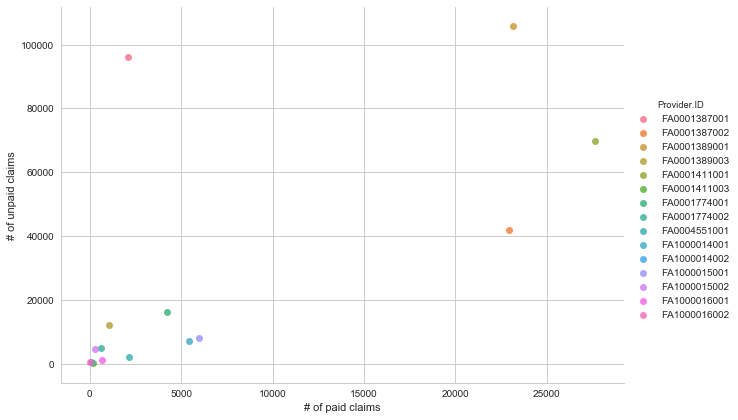

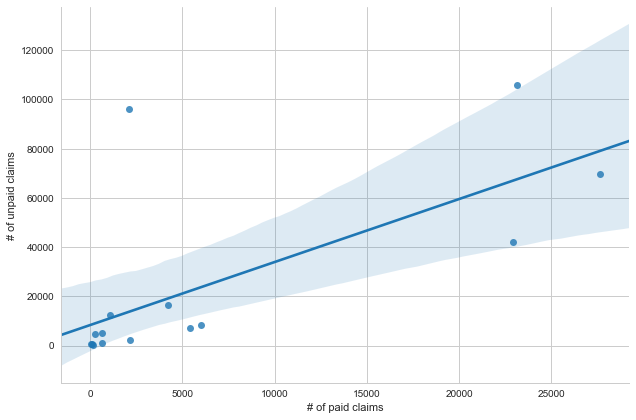

In [13]:
def unpaid_claims(x): 
    return len(x[x==0])
def paid_claims(x):
    return len(x[x>0])

claims_payment_data = (data_providers_with_J_codes.loc[:,['Provider.Payment.Amount',
                                                          'Provider.ID']]
                       .groupby('Provider.ID')['Provider.Payment.Amount']
                       .agg([paid_claims, unpaid_claims])
                       .reset_index()
                      )

sns.set_style('whitegrid')
sns.set_context("notebook")
(sns.lmplot(x='paid_claims', y='unpaid_claims', data=claims_payment_data, 
           fit_reg=False, hue='Provider.ID', scatter=True, size=6, aspect=1.5)
    .set_axis_labels('# of paid claims', '# of unpaid claims'));
(sns.lmplot(x='paid_claims', y='unpaid_claims', data=claims_payment_data, 
           fit_reg=True, scatter=True, size=6, aspect=1.5)
    .set_axis_labels('# of paid claims', '# of unpaid claims'));

In [14]:
claims_payment_data['payment_ratio'] = claims_payment_data.unpaid_claims/claims_payment_data.paid_claims
print claims_payment_data

     Provider.ID  paid_claims  unpaid_claims  payment_ratio
0   FA0001387001       2105.0        96002.0      45.606651
1   FA0001387002      22944.0        42027.0       1.831721
2   FA0001389001      23134.0       105818.0       4.574133
3   FA0001389003       1047.0        12206.0      11.658071
4   FA0001411001      27644.0        69708.0       2.521632
5   FA0001411003        148.0          361.0       2.439189
6   FA0001774001       4235.0        16387.0       3.869421
7   FA0001774002        629.0         5015.0       7.972973
8   FA0004551001       2160.0         2128.0       0.985185
9   FA1000014001       5417.0         7206.0       1.330257
10  FA1000014002         82.0          714.0       8.707317
11  FA1000015001       5997.0         8146.0       1.358346
12  FA1000015002        260.0         4697.0      18.065385
13  FA1000016001        662.0         1083.0       1.635952
14  FA1000016002         18.0          581.0      32.277778


In [15]:
# claims_payment_data['payment_ratio'].plot(figsize=[9,6]);

2. B. What insights can you suggest from the graph? 

The ratio of unpaid claims to paid claims for each provider is more-or-less constant, except for one provider, and the ratio is independent of the total number of claims.

2. C. Based on the graph, is the behavior of any of the providers concerning? Explain.

Yes, provider ID FA0001387001 seems to be submitting too many claims that are being rejected

3. Consider all claim lines with a J-code.

In [16]:
J_data = data.loc[(data.loc[:,'Procedure.Code'].str.startswith('J')),:]

3. A. What percentage of J-code claim lines were unpaid?

In [17]:
print 'Percentage of unpaid J-code claims = %', 
print round(len(J_data.loc[J_data.loc[:,'Provider.Payment.Amount'] == 0, :]
#                        .groupby('Claim.Line.Number')['Provider.Payment.Amount']
#                        .agg({'Paid.Claims.Ratio' : lambda x: float(paid_claims(x))
#                              /len(x)})
#                        ['Paid.Claims.Ratio'].value_counts()#.reset_index()
                      )/float(len(J_data))*100,2)

Percentage of unpaid J-code claims = % 88.11


3. B. Create a model to predict when a J-code is unpaid. Explain why you choose the modeling approach.

I'll use a Random Forest classifier to predict the payment of a claim. I pick random forest because: 
* It is fast
* It usually requires very little time to optimize it (its default params are often close to the best ones)
* it is resilent with outliers, irrelevant variables, continuous and discrete variables. 

Also, I will build a simple tree to find the most important paramters.

**At least for now, droping unrelevant features; features that don't know the meaning or know they are not important**

In [18]:
drop_columns = ['Claim.Number', 'Member.ID', 'Group.Index', 'Capitation.Index',
                'Place.Of.Service.Code', 'Procedure.Code','Price.Index', 'Pricing.Index', 
                'Reference.Index', 'Subscriber.Index', 'Subgroup.Index', 'Claim.Pre.Prince.Index',
                'Denial.Reason.Code','Claim.Current.Status']
cat_columns  = ['Claim.Line.Number', 'Provider.ID', 'Line.Of.Business.ID', 
                'Revenue.Code', 'Service.Code', 'Diagnosis.Code', 
                'In.Out.Of.Network', 'Claim.Type', 'Claim.Subscriber.Type',
                'Network.ID','Agreement.ID']
J_data = J_data.drop(labels=drop_columns, axis=1).reset_index(drop=True)
# J_data[cat_columns] = J_data[cat_columns].astype('category')
J_data.loc[:,cat_columns] = J_data.loc[:,cat_columns].apply(lambda x: x.cat.remove_unused_categories())
# J_data.info()

In [19]:
J_data.head()

,Claim.Line.Number,Provider.ID,Line.Of.Business.ID,Revenue.Code,Service.Code,Diagnosis.Code,Claim.Charge.Amount,In.Out.Of.Network,Subscriber.Payment.Amount,Provider.Payment.Amount,Claim.Type,Claim.Subscriber.Type,Network.ID,Agreement.ID
0,10,FA0001389001,0005,0636,OP7O,4359,592.201995,I,0.0,0.0,M,H,P00000000001,FH001309QB01
1,8,FA0001389001,0001,0636,OP7O,64303,118.832970,I,0.0,0.0,M,H,H00000000001,FH001886QH01
2,9,FA0001389001,0001,0636,OP7O,64303,196.890405,I,0.0,0.0,M,H,H00000000001,FH001886QH01
3,10,FA0001389001,0005,0636,OP7O,4359,592.201995,I,0.0,0.0,M,H,P00000000001,FH001309QB01
4,10,FA0001389001,0005,0636,OP7O,4359,592.201995,I,0.0,0.0,M,H,P00000000001,FH001309QB01


In [20]:
X = J_data.drop(labels='Provider.Payment.Amount', axis = 1)
y = J_data['Provider.Payment.Amount']

In [21]:
X = pd.get_dummies(X)
# X.head()

In [22]:
y = y.map(lambda x: 1 if x > 0 else 0)
y.value_counts()

0    44961
1     6068
Name: Provider.Payment.Amount, dtype: int64

In [23]:
clf = RandomForestClassifier(oob_score=True, class_weight='balanced', n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train,y_train)

print 'OOB estimate of  error rate =', round(clf.oob_score_,2)

y_pred = clf.predict(X_train)
cfm = confusion_matrix(y_train, y_pred)
# plt.figure()
# sns.heatmap(cfm, annot=True, fmt="d", linewidths=.5, center=cfm.mean());

print 'Test set error rate =', round(clf.score(X_test, y_test), 2)

y_pred = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_pred)
# plt.figure()
# sns.heatmap(cfm, annot=True, fmt="d", linewidths=.5, center=cfm.mean());
# clf = clf.fit(X, y)
# print clf.oob_score_
# clf.feature_importances_  

OOB estimate of  error rate = 0.95
Test set error rate = 0.95


3. C. How accurate is your model at predicting unpaid claims?

In [24]:
print classification_report(y, clf.predict(X))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99     44961
          1       0.88      0.93      0.91      6068

avg / total       0.98      0.98      0.98     51029



Area Under Curve: 0.96
Average precision-recall score: 0.96


Text(0.5,1,'2-class Precision-Recall curve: AP=0.96')

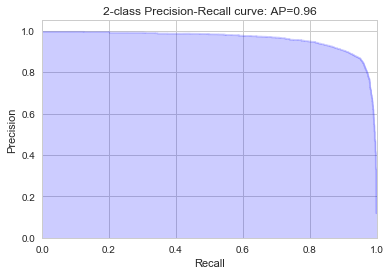

In [25]:
precision, recall, _ = precision_recall_curve(y, clf.predict_proba(X)[:,1])
area = auc(recall, precision)
print "Area Under Curve: %0.2f" % area

average_precision = average_precision_score(y, clf.predict_proba(X)[:,1])
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

3. D. What data attributes are predominately influencing the rate of non-payment?

In [26]:
model = SelectFromModel(clf, prefit=True, threshold = clf.feature_importances_.mean())
n_features = model.transform(X).shape[1]

# Reset the threshold till the number of features is less than 10.
while n_features > 10:
    model.threshold += 0.01
    X_transform = model.transform(X)
    n_features = X_transform.shape[1]
    
X_new = pd.DataFrame(model.transform(X), columns=X.columns[model.get_support()])

In [27]:
X_new.head()

,Claim.Charge.Amount,Line.Of.Business.ID_,Service.Code_OP7O,Service.Code_SU7A,In.Out.Of.Network_I,Network.ID_,Agreement.ID_
0,592.201995,0.0,1.0,0.0,1.0,0.0,0.0
1,118.832970,0.0,1.0,0.0,1.0,0.0,0.0
2,196.890405,0.0,1.0,0.0,1.0,0.0,0.0
3,592.201995,0.0,1.0,0.0,1.0,0.0,0.0
4,592.201995,0.0,1.0,0.0,1.0,0.0,0.0


In [28]:
clf = DecisionTreeClassifier(max_depth=4,
                             min_samples_leaf = len(X_new)//100,
                             class_weight = 'balanced'
                            )
clf.fit(X_new,y)
print(clf.score(X_new, y))

0.779929059946305


In [29]:
print 'Top 8 features and their importances:'
for x, i in zip(X_new.columns, clf.feature_importances_):
    print x, '-->', round(i,3)



Top 8 features and their importances:
Claim.Charge.Amount --> 0.026
Line.Of.Business.ID_  --> 0.639
Service.Code_OP7O --> 0.335
Service.Code_SU7A --> 0.0
In.Out.Of.Network_I --> 0.0
Network.ID_  --> 0.0
Agreement.ID_  --> 0.0


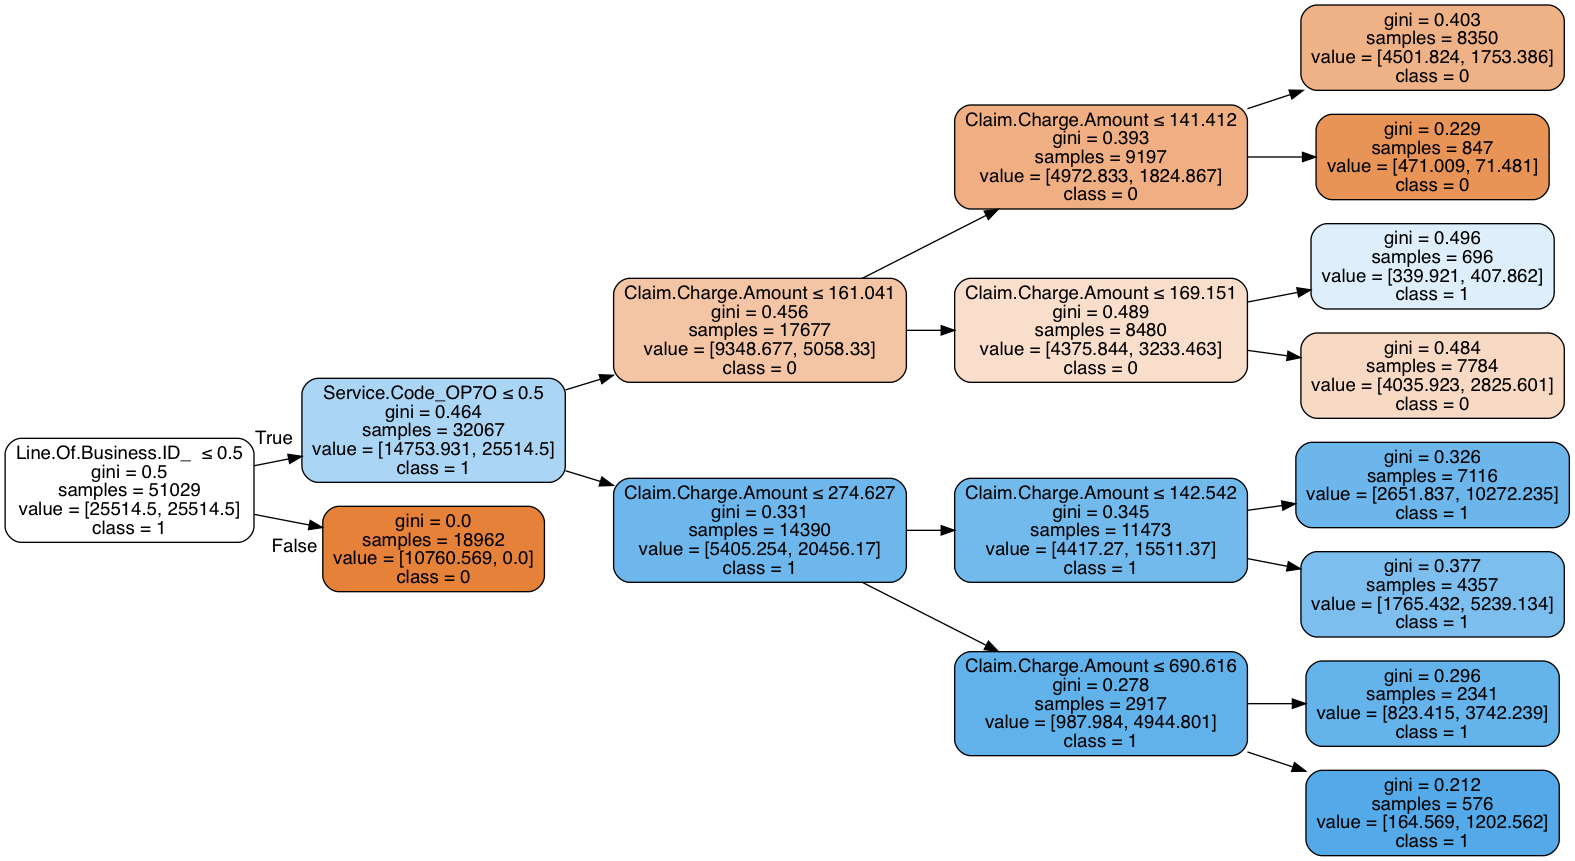

In [30]:
tree = export_graphviz(clf, feature_names=X_new.columns, 
                       class_names=['0', '1'], filled=True, rounded=True,
                       out_file=None, special_characters=True, rotate=True)

graph = graph_from_dot_data(tree)
Image(graph.create_png())

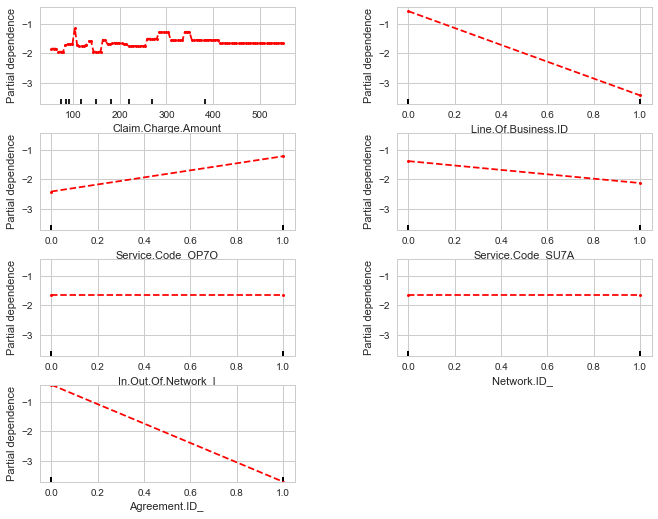

In [31]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(X_new, y)
features = X_new.columns.values
names = X_new.columns.values
fig, axs = plot_partial_dependence(clf, X_new, features, feature_names=names
                                   , n_cols=2, figsize=(10,12),
                                   line_kw={'linestyle':'--', 'marker':'o', 
                                            'color':'red', 'markersize':3})